## Hand-on activity

We will run a first version of an ARIMA-SARIMA model for the IGAE index (Índice Global de Actividad Económica) developed by INEGI (Instituto Nacional de Estadística y Geografía). Since 1993 INEGI calculates this index based on the Mexican general economy and different industry sectors.

## Data collection and data management

IGAE is an indicator about the economic activity in Mexico. Although the Mexico GDP is a very close measure of all products and services produced in Mexico, the IGAE is a good indicator about the Mexico Economic development. Unlike the GDP, which is published each Quarter, the IGAE is published each month, and it is usually published much faster than the GDP.

You can download the IGAE directly from the INEGI web site in different formats such as Excel format. Also, INEGI offers an automatic way to download most of its historical indicators using an API that can be accessed with different computer languages.

Here is the Python code to download the monthly IGAE up to the most recent month:

In [246]:
import requests
import pandas as pd
# Code to download the IGAE index from the INEGI site:
token = 'c4559227-83d3-aeb4-1a8d-bee73f627140'

igae_id = '737121'

url =  f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{igae_id}/es/0700/false/BIE/2.0/{token}?type=json'

response = requests.get(url)
data = response.json()
series = data.get('Series', [])
observations = series[0].get('OBSERVATIONS', [])
igaedf = pd.DataFrame(observations)
# Convert the month to a date type variable: 
igaedf['TIME_PERIOD'] = pd.to_datetime(igaedf['TIME_PERIOD'], format='%Y/%m')
# Convert the IGAE index to a numeric variable: 
igaedf['OBS_VALUE'] = pd.to_numeric(igaedf['OBS_VALUE'], errors='coerce')
# Keep only the columns we need
igaedf = igaedf[['TIME_PERIOD', 'OBS_VALUE']]
# Rename the columns:
igaedf.columns = ['Month', 'IGAE']
# Setting the month as the index of the series:
igaedf = igaedf.set_index('Month')
# Sorting the data according to the index:
igaedf = igaedf.sort_index()
# Display the first few rows
print(igaedf.head())

                 IGAE
Month                
1993-01-01  55.434736
1993-02-01  56.456971
1993-03-01  58.900549
1993-04-01  57.135844
1993-05-01  57.891853


We can plot the index over time to have an idea about the Mexico economic development over time:

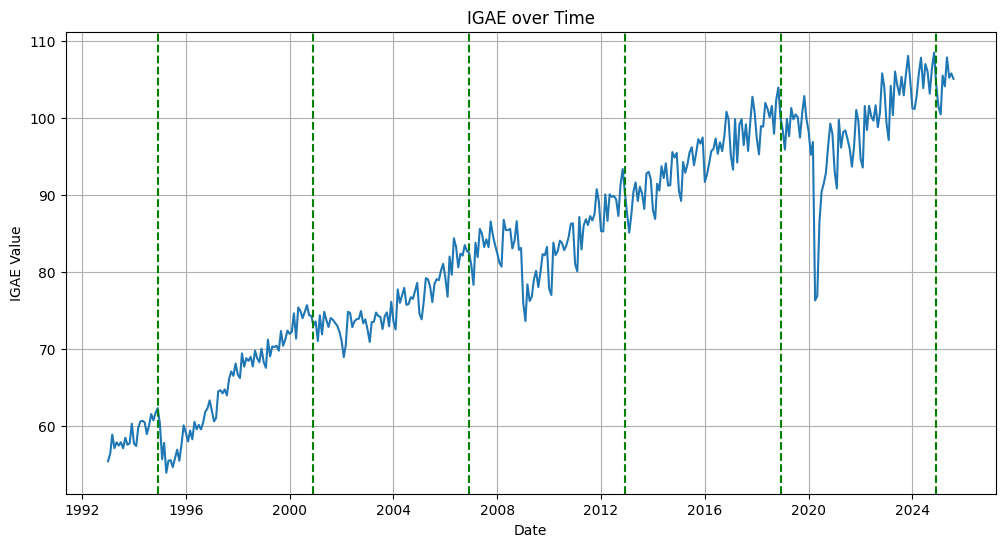

In [247]:
# prompt: plot the IGAE from df, and trace a vertical line in Dec 2018 and Dec 2024

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, igaedf['IGAE'])
plt.title('IGAE over Time')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)

# Trace vertical lines to identify the 6-year government periods
plt.axvline(pd.to_datetime('1994-12-01'), color='green', linestyle='--')
plt.axvline(pd.to_datetime('2000-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2006-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2012-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2018-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2024-12-01'), color='green',linestyle='--')

plt.show()

## Stationary vs Non-stationary

What do you observe? Compared to previous crisis in Mexico during 1994-1995 and 2008-2009, how does the COVID crisis look like?

We see that the decline of the index for the COVID crisis looks much profound compared with previous crisis (2008 mortgage crisis and the internal 1994 crisis). It is possible that for very old periods, the decline in magnitud looks shorter compared to the magnitude decline of a recent period. What matters to understand the economic development is the percentage changes of the economic output. The best way to visually identify which recession period had was the worse % decline is by looking at the log value of the index.

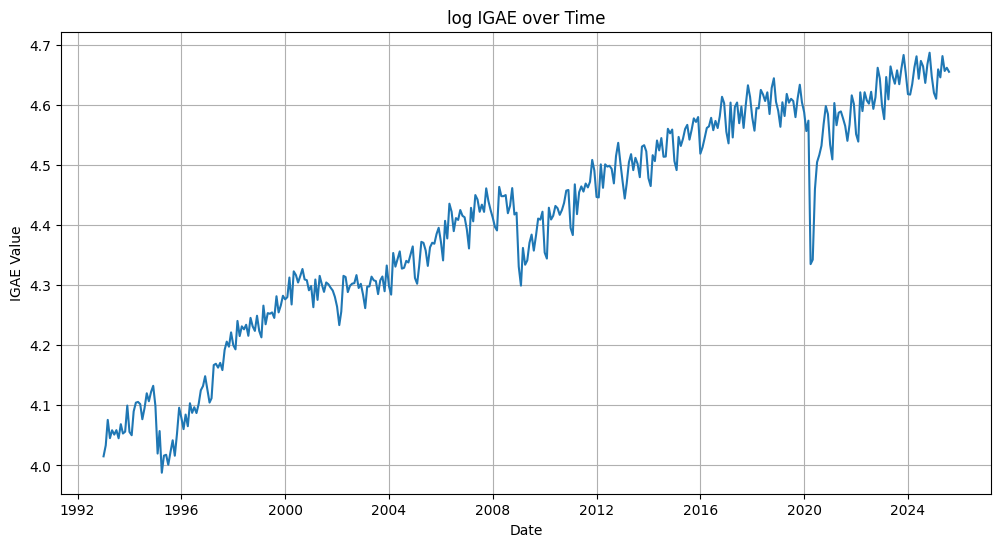

In [248]:
import numpy as np 
igaedf['logIGAE'] = np.log(igaedf['IGAE'])

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, igaedf['logIGAE'])
plt.title('log IGAE over Time')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.show()

With the log of the index we can clarly appreciate that the COVID crisis/recession period had the more pronounced decline compared to other periods. In the COVID period we can see that the log of the index moved from about 4.6 to about 4.35. If we take the difference between these values (4.60 - 4.35 = 0.25) we can have a quick idea about the % decline in the Economy in the COVID period, which was about -25% from Jan 2020 to March-Apr 2020!

It is clear that the log series is not stationary, so I do not need to run a Dicky-Fuller test to check stationarity for the log. I have to do a difference of the series and then do the Dicky-Fuller test.

For financial and economic monthly data it is recommended to start calculating the seasonal (annual) log difference and check whether this series is stationary. If it is, then use this version for the model.

In case that the seasonal log difference is not stationary, then you can calculate the first difference, and most of the time this first difference will be stationary.

Then, we start checking whether the seasonal log of the IGAE is a stationary series. We start with a plot of this variable, and then run the the corresponding Dicky-Fuller test:

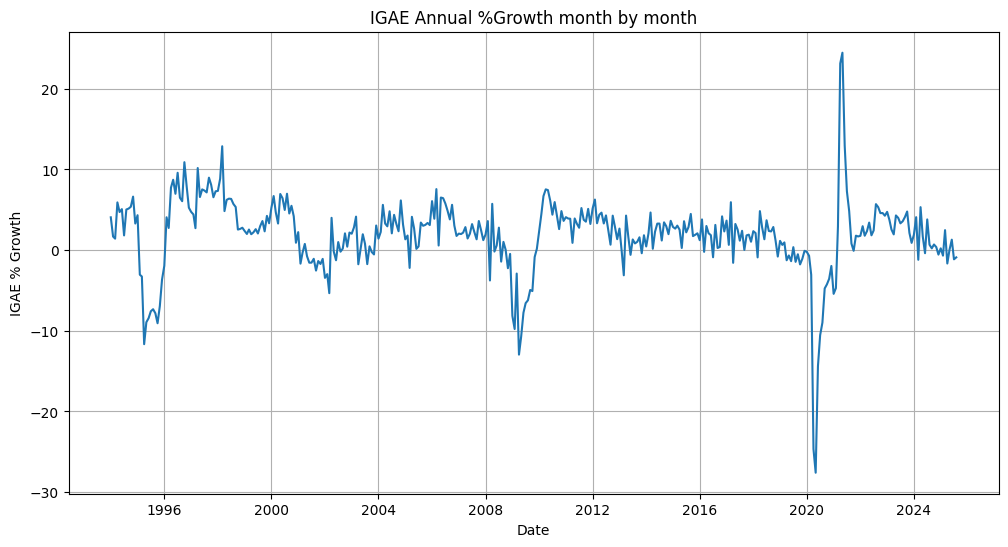

In [249]:
igaedf['annualgrowth'] = igaedf['logIGAE'] - igaedf['logIGAE'].shift(12)
# We can also do this annual growth by using the diff function:
# igaedf['annualgrowth2'] = igaedf['logIGAE'].diff(12)

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, 100*igaedf['annualgrowth'])
plt.title('IGAE Annual %Growth month by month')
plt.xlabel('Date')
plt.ylabel('IGAE % Growth')
plt.grid(True)
plt.show()

The seasonal log difference of the series is actually the annual % change month by month of the IGAE (in continuously compounded percentages).

Let’s see why the seasonal log difference is the annual % change of the series:

diff(logigae,12) = logigae - lag(logigae,12)

lag(logigae,12) is the value of the log IGAE, but 12 months ago!

In this case the diff function gets the difference from a current value of the log minus the log value 12 months ago. This is actually a % annual change since we are taking the difference with 12 months ago.

It is hard to our eyes to see whether the seasonal log series is stationary. We need to run the Dicky-Fuller test:



In [250]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(igaedf['annualgrowth'].dropna())

# Print the results
print('ADF Statistic: %f' % dftest[0])

ADF Statistic: -3.962962


In [251]:
print('p-value: %f' % dftest[1])

p-value: 0.001617


In [252]:
print('Critical Values:')

for key, value in dftest[4].items():
  print('\t%s: %.3f' % (key, value))

Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Since the p-value of the Dicky-Fuller test is 0.001<0.05, then we can reject the null hypothesis (phi1=1 or that the Series is NOT STATIONARY) and accept the alternative hypothesis (the series is STATIONARY). Then we can conclude that the annual % growth (seasonal log of the IGAE) is a stationary series. Then we will use this version of the variable for our model.

## Autocorrelations (AC) and Partial-autocorrelations (PAC)

Once we determine which version of the variable is stationary, then we need to examine autocorrelations and partial autocorrelations of this variable. We can examine this with a correlogram.

In time series analysis, a correlogram is an chart of correlation statistics also known as an autocorrelation plot. This is a plot of the sample autocorrelations of the dependent variable $ Y_t $ and the time lags. In R, the function to compute the autocorrelations is acf2() from the astsa package, which gives you both, the autocorrelation (ACF) figures and the partial-autocorrelations (PACF), as well.

Let’s examine the autocorrelations of the seasonal log of the IGAE.

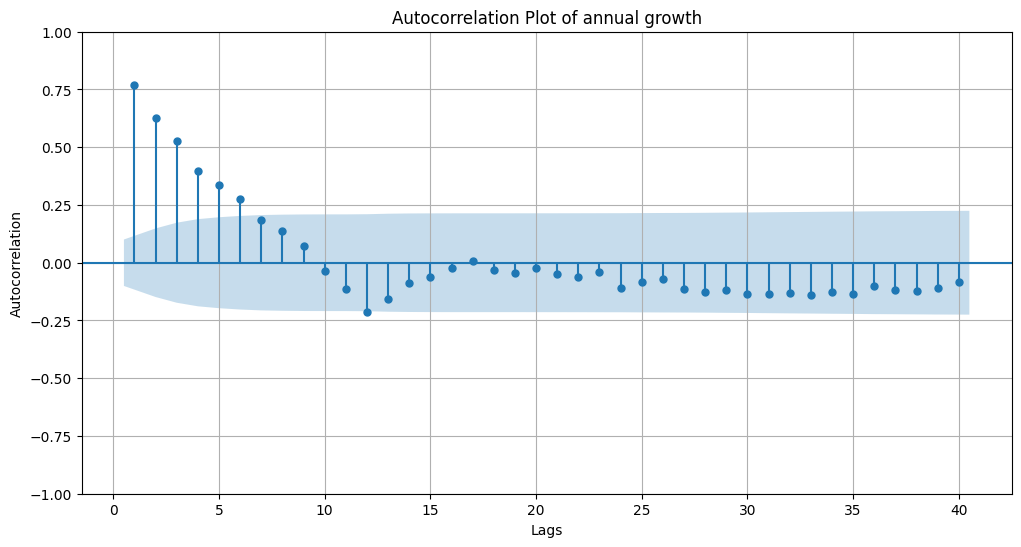

In [253]:
# prompt: Using igaedf, Do an autocorrelation plot and a partial autocorrelation plot of 'annualgrowth'

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Drop NaN values created by the differencing
annual_growth = igaedf.dropna(subset=['annualgrowth'])

# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(annual_growth['annualgrowth'], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

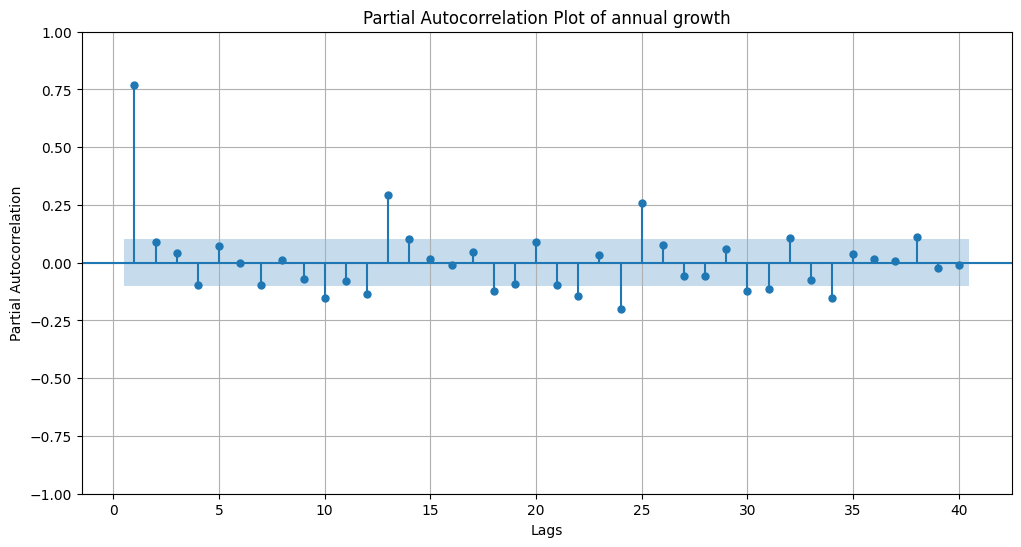

In [254]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(annual_growth['annualgrowth'], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

The plot_acf() function gives you the autocorrelogram, which is the autocorrelations in a graph where it is easy to identify which lags of the variable have a significant autocorrelation.

The X axis represents the lag numbers, while the Y axis is the level of autocorrelation. The vertical lines are the levels of autocorrelations between the current value of $ Y(Y_t) $ and its own lags $ (Y_{t-1}, Y_{t-2}...).$

The dotted, blue line delimits the 95% confidence interval for the autocorrelations. Then, if the autocorrelation goes out of the 95% C.I., then the autocorrelation of the variable $ Y_t $ with its corresponding lag $ Y_{t-1} (AutoCorr(Y_t, Y_{t-1})) $ is statistically different than zero.

We can see that the LAG 1 $ (Y_{t-1}) $ is significantly autocorrelated (positively) with the current value of the variable $ (Y_t) $ since this autocorrelation is significantly greater than zero.

What is the meaning of the first significant LAG? In this case, this means that the value of $ Y $ at any point in time $ t $ has an average autocorrelation about 0.80 with its own value at $ t-1 $. We can see this 0.80 as the height of the first vertical line of the ACF plot.

The autocorrelation of $Y_t$ with its previous value $Y_{t-1}$ can be calculated manually as the correlation, which is equal to their covariance divided by the product of their standard deviation.

Remembering the formula for correlation between 2 variables Y and X:

$$ CORR(Y, X) = \frac{COV(Y,X)}{SD(Y) * SD(X)}$$

In the case of “Autocorrelation”, we only have one variable $Y$, so we are looking at the correlation of $Y_t$ with its own previous value $Y_{t-1}$. Then, applying the correlation formula between $Y_t$ and $Y_{t-1} (instead of X)$, we can calculate this autocorrelation as:

$$ AUTOCORR(Y, Y_{t-1}) = \frac{AUTOCOV(Y,Y_{t-1})}{SD(Y) * SD(Y_{t-1})}$$

Since $Y$ is supposed to be stationary series, then the standard deviation of $Y_t$ has to be the same as the standard deviation of $Y_{t-1}$. Then: 

$$ AUTOCORR(Y, Y_{t-1}) = \frac{AUTOCOV(Y,Y_{t-1})}{VAR(Y_t)} = \frac{\gamma(1)}{\sigma^2_y}$$

Fortunately, R does the calculation of all the autocorrelations of $Y_t$ with its own lags, and these autocorrelations are plotted using the acf2 command (as seen above).

Unlike the ACF plot, the partial-autocorrelation (PACF) plot shows the autocorrelation of the lag with the variable after considering the effect of the lower-order autocorrelations.

The autocorrelation and partial autocorrelation between $Y_t$and its LAG 1 $(Y_{t-1})$ are the same, since there is no lower-order autocorrelations for LAG 1.

The autocorrelation between $Y_t$ and its LAG2 $(Y_{t-2})$ and the partial autocorrelation between $Y_t$ and its LAG2 $(Y_{t-2})$ will be different since the partial autocorrelation is calculated AFTER the autocorrelation between $Y_t$ and $Y_{t-1}$ is taken into consideration.

In other words, the PACF plot shows the amount of autocorrelation between $Y_t$ and its lag $K (Y_{t-k})$ that is not explained by all the lower-order autocorrelations $(Y_t with (Y_{t-k-n}))$.

The ACF plot shows that only the LAG 1 autocorrelation is positive and significant, and the following LAG autocorrelations are also positive but not significant.

We see a fast decay in the magnitude of the LAG autocorrelations in the PACF, and a low decay in the magnitude of the LAG autocorrelations in the ACF plot.

In the partial autocorrelation (PACF) we can see that ONLY the autocorrelation of LAG 1 is significant and positive, and immediately the rest of the autocorrelation go close to zero suddenly. This is a classical AR(1) signature with 1 AR terms. We do not need to include other terms further than LAG 1.

Then we can see that the partial autocorrelation plot (PACF) helps us to identify the # of AR terms. Then, according to this PACF we see that only LAG 1 is autocorrelated with the current value AFTER considering the effect of the lower-level autocorreations of lags 2,3,4, etc. In other words, the annual %change in the IGAE of the current month seems to be positively correlated with its own annual % changes of the previous month.

## Calibrating the ARMIA-SARIMA model

The objective of the calibration of an ARIMA-SARIMA model is to find the right values for p, d, q, P, D and Q.

The values for d and D are already defined when we found the transformation of the variable that became stationary. In this case, we found that the seasonal difference of the log of IGAE is stationary, so the parameters for d and D are:

d=0, D=1

If D=1 it means that we are doing a seasonal difference (annual % growth), and d=0 indicates that we are NOT doing a first difference (monthly % growth).

Next step is to define the parameters p and q. The p parameter refers to the number of AR terms, while the q parameters refers to the number of MA terms in the model.

There mainly 2 set of possible initial values for p and q:

1. p=1, 2 or 3, and q=0: This is when we observe an AR pattern (also called AR signature) in the AC and the PAC Plots.

An AR signature can be observed when the AC Plot shows positive autocorrelations for the first lags that gradually decay over time, and the PAC autocorrelations show 1, 2 or 3 positive and significant autocorrelations that drastically decay after few lags. In our AC Plot we saw this AR signature.

When we have an AR signature, the best configuration for p = number of significant autocorrelations in the PAC Plot, and the value for q is set to zero (q=0).

2. p=0, and q=1, 2 or 3: This happens when we observe an MA pattern (also called MA signature) in the AC and the PAC Plots

An MA signature can be observed when the AC Plot and the PAC Plot show very few negative significant autocorrelations (usually only 1), and the PAC autocorrelations decay more gradually than the AC autocorrelations.

When we have an MA signature, the best configuration is q = number of significant autocorrelations in the AC Plot, and set the value of p = 0.

Then, in our example we see an AR signature with p = 1 and q = 0. We keep P and Q equal to zero up to this point. Let’s start running the ARIMA-SARIMA model with these values

In [255]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

igae_log = igaedf['logIGAE'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 0), 
                seasonal_order=(0, 1, 0, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 801.153
Date:                            Wed, 12 Nov 2025   AIC                          -1596.306
Time:                                    18:52:24   BIC                          -1584.486
Sample:                                01-01-1993   HQIC                         -1591.616
                                     - 08-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0043      0.002      2.859      0.004       0.001       0.007
ar.L1          0.7694      0.021   

/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [256]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']

print('phi0 = intercept = %f' % phi0)

phi0 = intercept = 0.004334


In [257]:
print('phi1 = %f' % phi1)

phi1 = 0.769374


The ARIMA SARIMA model estimated values for $\phi_1 = 0.7694$, while the $\phi_0 = 0.0043$ and both had are significantly positive since their p-values are much less than 0.05. The next step is to check whether the errors (residuals) of this model looks like a white noise. A white noise is a time series that has no significant autocorrelation with any of its past values (lags). Then, we check the AC Plot and the PAC Plot of the model residuals:

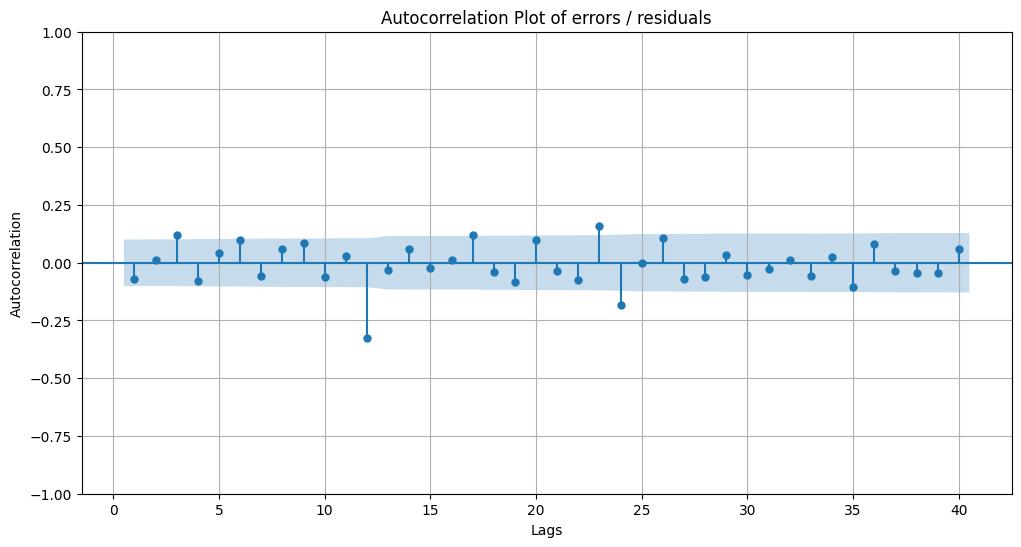

In [258]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

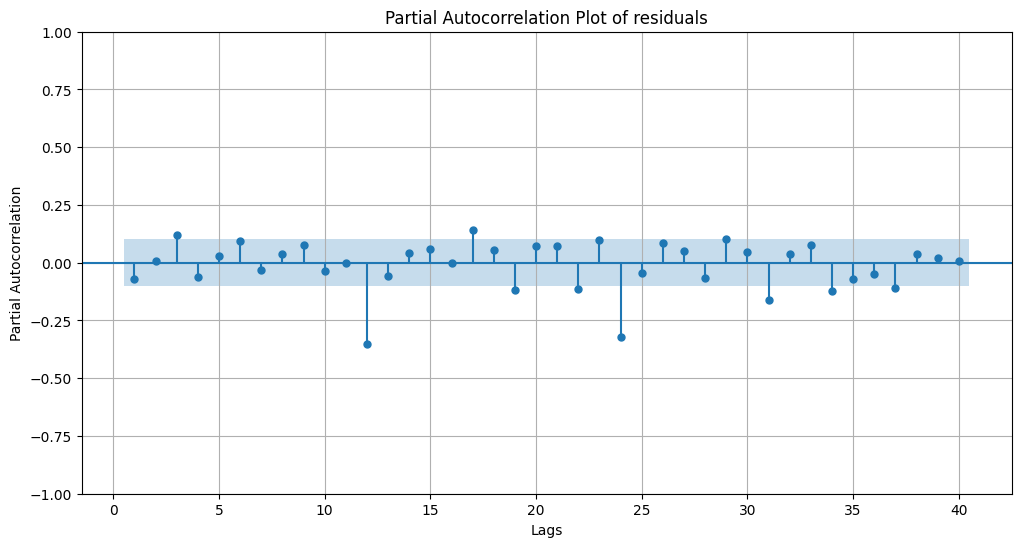

In [259]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

We see that in both plots, the AC and the PAC plot, the autocorrelation of the residuals with its own lag 12 is negative and significant. This means that we can incorporate in the model a seasonal term P=1 or Q=1 to account for this significant autocorrelation.

As a rule of thumb, when this happens, if the significant autocorrelation is negative in both plots, we start selecting a seasonal MA term and NO AR terms. In other words, we start setting the values for P and Q as:

P = 0

Q = 1

We re-run the model with this change to the values of P and Q:

In [260]:
igae_log = igaedf['logIGAE'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 0), 
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                              logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 864.452
Date:                              Wed, 12 Nov 2025   AIC                          -1720.904
Time:                                      18:52:27   BIC                          -1705.144
Sample:                                  01-01-1993   HQIC                         -1714.650
                                       - 08-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.000      6.752      0.000       0.002       0.003
ar.L1          0.86

We can save the coefficients of the model:

In [261]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)

phi0 = intercept = 0.002591


In [262]:
print('phi1 = %f' % phi1)

phi1 = 0.861471


In [263]:
print('theta1 = %f' % theta1)

theta1 = -0.817436


The seasonal MA term was -0.8174, and was statistically significant since its p-value is much less than 0.05. Then we keep it in the model.

Now we again check whether the residuals of this second model has a signficiant autocorrelation with its own values:

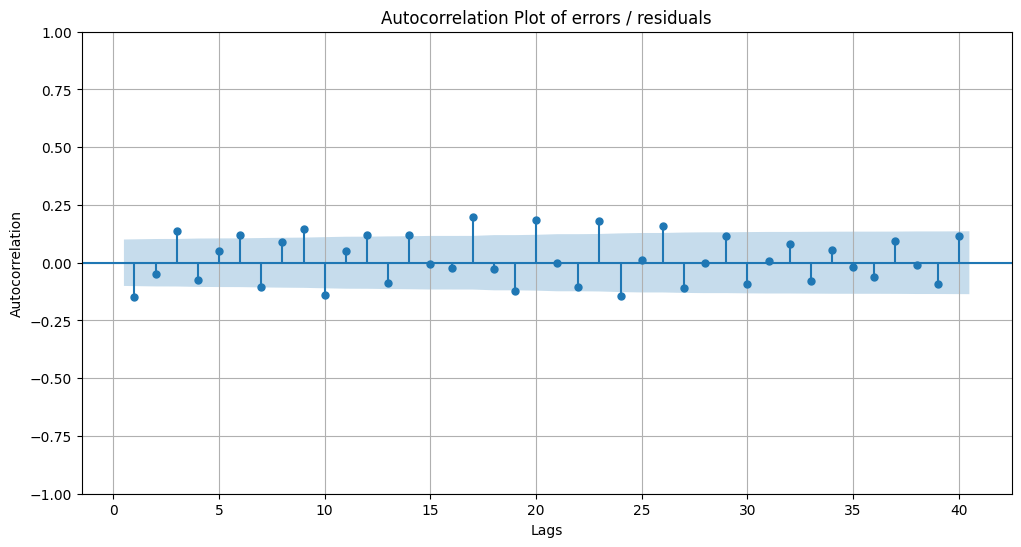

In [264]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

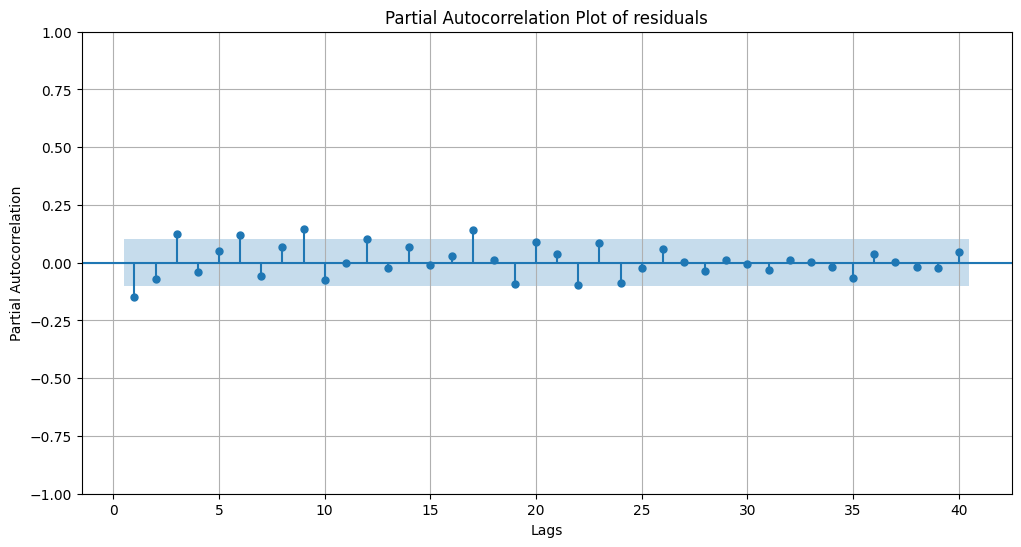

In [265]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

We see that both AC and PAC plot show a negative and positive autocorrelagion with its lag 1. Then, we change the q from 0 to 1 to account (include the MA(1) term) for this autocorrelation. We do this since this autocorrelation is negative and we already had included an AR(1) term.

In [266]:
# Fit SARIMA model ARIMA(p=1,d=0,q=1) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 864.619
Date:                            Wed, 12 Nov 2025   AIC                          -1719.239
Time:                                    18:52:31   BIC                          -1699.538
Sample:                                01-01-1993   HQIC                         -1711.421
                                     - 08-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.001      4.632      0.000       0.002       0.005
ar.L1          0.8225      0.034   

We can save the coefficients of the model:

In [267]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.L1']
theta2 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)

phi0 = intercept = 0.003325


In [268]:
print('phi1 = %f' % phi1)

phi1 = 0.822456


In [269]:
print('theta1 = %f' % theta1)

theta1 = -0.158917


In [270]:
print('theta2 = %f' % theta2)

theta2 = -0.786725


We see that all coefficients of the model are statistically significant since their pvalues < 0.05. Then, we keep them in the model.

We again check whether the model residuals show autocorrelation with its own lags:

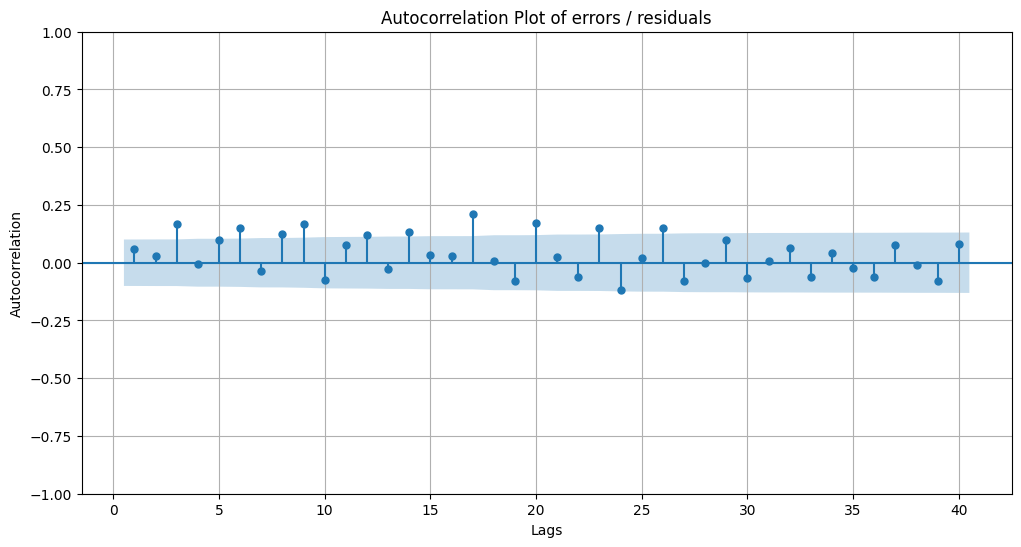

In [271]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

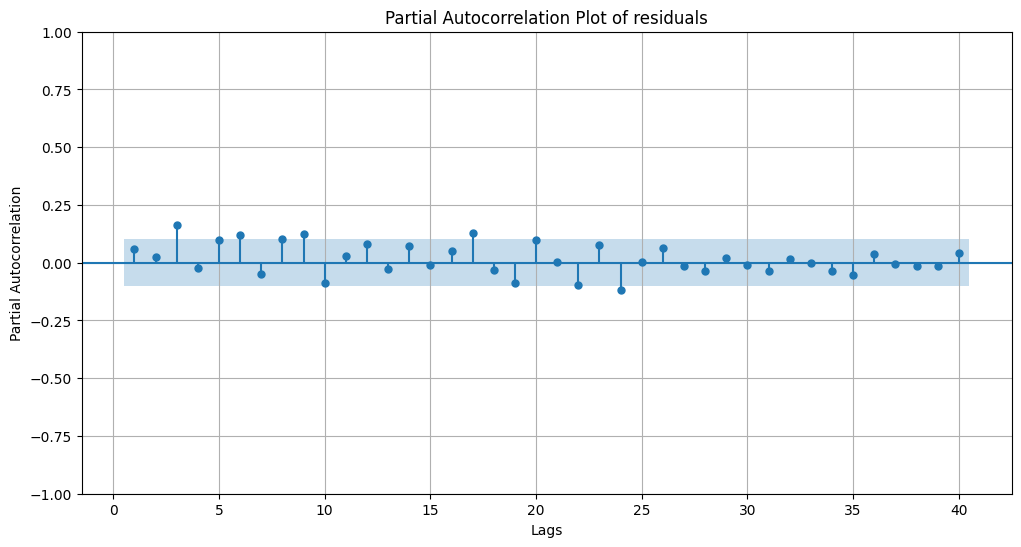

In [272]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Now we see that the autocorrelations of residuals with its own past values (lags) are not significant (in general). We can see that in both the AD and PAC plots there are some barely significant autocorrelations for lags 7 and lag 10.

We could include AR or MA terms to account for these lags. However, in my own experience, when working with monthly data of economic/financial series, I recommend ONLY including terms for lags = 1 (last month), 2 (last 2 months), and 6 (last semester). Then, I accept the model errors like a white noise. Then, I stop here the calibration process.

Then the final calibration of the model ended up with the following parameters:

p = 1, d = 0, q = 1

P = 0, D = 1, Q = 1

In other words, we have an ARIMA(p=1, d=0, q=1) SARIMA(P=0, D=1, Q=1)

We can express the results of this model following the ARIMA-SARIMA equation:

$$ Y_t = \phi_0 + \phi_1Y_{t-1} + \theta_1error_{t-1} + \theta_2error_{t-12} + error_t$$

Where $Y_t$ is the annual % growth of the IGAE (the seasonal difference of the log).

he sum of the $\phi_i$ oefficients must always be less than 1. If you find that the sum of these coefficients is bigger than 1, then you need to review the calibration process.

According to the result, we can see that the coefficients $\phi_1$ is positive and significant (since its p-value are <0.05). Then we can say that the IGAE annual % change is positively and significantly related with its own annual % change of 1 month ago.

Also, the $\theta_1$ oefficient (the MA coefficient) is negative and significant. This means that the annual % growth of the IGAE is negatively related with the error (shock) of 1 month ago. The $\theta_2$ coefficient (the seasonal MA coefficient) is negative and very significant. This means that the annual % growth of the IGAE is negatively related with the error (shock) of 12 months ago.

Now we can use this model to do predictions:

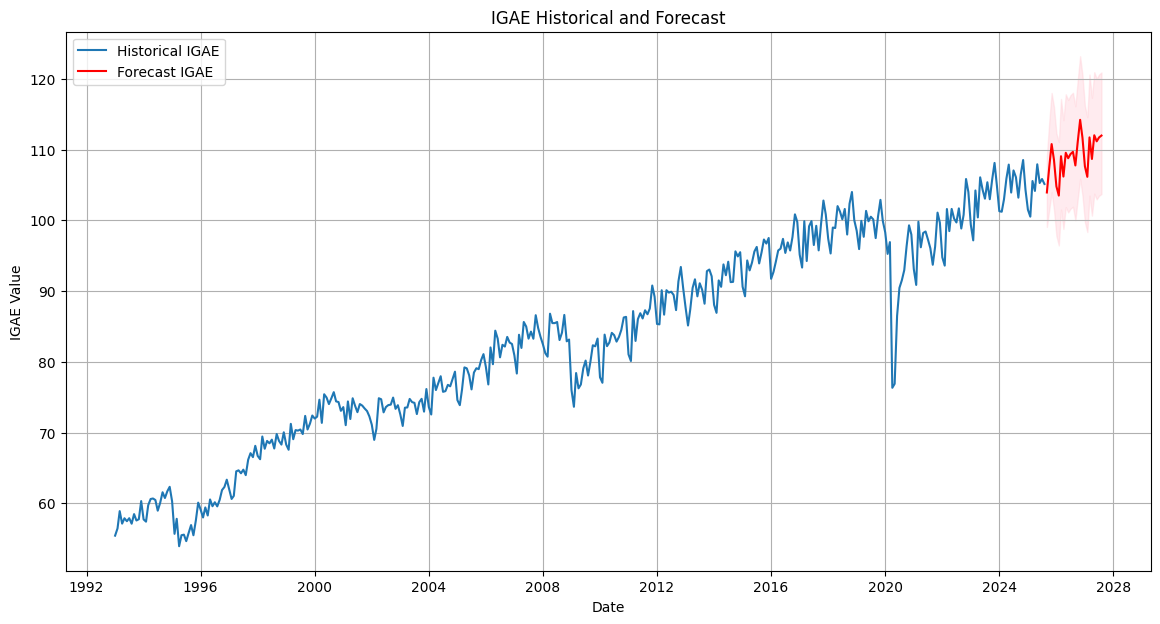

In [273]:
# I will forecast 24 months in the future:
forecast_steps = 24
forecast_result = result.get_forecast(steps=forecast_steps)
# I get the mean forecast:
forecast_log = forecast_result.predicted_mean
# Get the 95% confidence interval of the forecast: 
# alpha = 1 - confidence interval
forecast_ci = forecast_result.conf_int(alpha=0.05)

# Convert log forecast values back to original scale of IGAE
forecast_values = np.exp(forecast_log)

# Plot historical and forecast values
plt.figure(figsize=(14, 7))
plt.plot(igaedf.index, igaedf['IGAE'], label='Historical IGAE')
plt.plot(forecast_values.index, forecast_values, label='Forecast IGAE', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval

plt.title('IGAE Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.legend()
plt.show()

## INTERPRETATION OF THE ARIMA-SARIMA MODEL
I re-run the last model to see the coefficients and their pvalues:

In [274]:
# Fit SARIMA model ARIMA(p=1,d=0,q=1) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 864.619
Date:                            Wed, 12 Nov 2025   AIC                          -1719.239
Time:                                    18:52:34   BIC                          -1699.538
Sample:                                01-01-1993   HQIC                         -1711.421
                                     - 08-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.001      4.632      0.000       0.002       0.005
ar.L1          0.8225      0.034   

I start identifying the version of the variable that I am modelling with this ARIMA-SARIMA. Since d=1 and D=1 and I use the log of the GDP, then I am modelling the annual % change of the Mexico GDP.

Then, Y = GDP annual % change

Looking at the coefficients:

* AR(1) coefficient or $\phi_1 = +0.93$. This means that the GDP annual % change is positively and significantly (its pvalue<0.05) autocorrelated in 93% with its own annual % change of the previous quarter. Then, if the previous quarter the GDP annual % change was positive, it is very likely that this quarter will also be positive; also, if the previous quarter the annual %change was negative, then it is very lilkely that this quarter will also be negative.

* MA(1) coefficient or $\theta_1 = -0.25$. This means that the GDP annual % change is negatively and significantly related with the errors (shocks) of the previous quarter.

* Seasonal MA(1) coefficient or $\theta_2 = -0.83$. This means that the GDP annual % change is negatively and significantly related with the errors (shocks) of the previous year (4 quarters ago) in about -83%.

# Challenge 1

Download the Real Gross Domestic Product for Mexico from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:

a. Calibrate an ARIMA-SARIMA to forecast the Mexico GDP for the the rest of 2025 and all quarters of 2026.

b. You have to explain your calibration steps, and

c. Interpret the final model.

## Obtención de los datos

In [275]:
import pandas_datareader as pdr
# This part is already done in the preceding code.
series_id = "NGDPRNSAXDCMXQ" 
mxgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
mxgdpdf.columns=['MXGDP']
print(mxgdpdf.head())

                MXGDP
DATE                 
1993-01-01  3439763.5
1993-04-01  3472286.3
1993-07-01  3465719.7
1993-10-01  3519338.2
1994-01-01  3525020.1


## Visualización del PIB

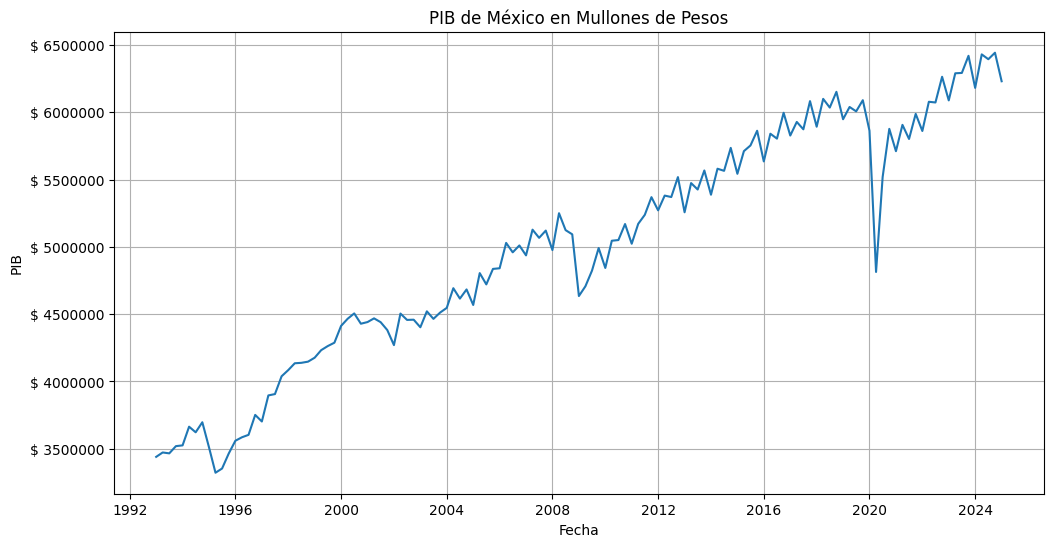

In [276]:
import matplotlib.ticker as mticker
plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'])
plt.title('PIB de México en Mullones de Pesos')
plt.xlabel('Fecha')
plt.ylabel('PIB')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

## Diferencia de periodo y crecimeinto anual

Obtenemos la primera diferencia de periodo, dado que el crecimiento del PIB en México no muestra estacionariedad.

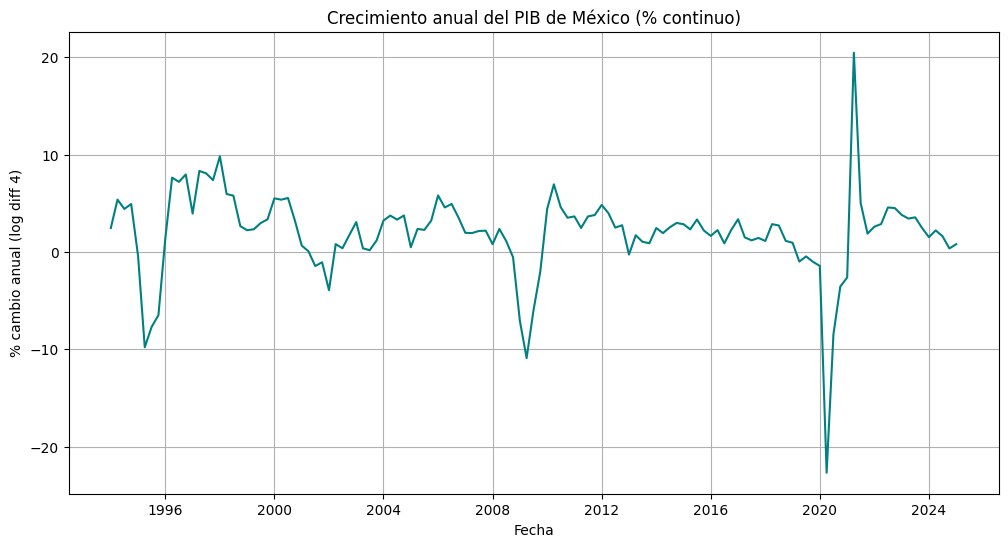

In [277]:
mxgdpdf["logMXGDP"] = np.log(mxgdpdf["MXGDP"])
mxgdpdf["annualGrowth"] = mxgdpdf["logMXGDP"].diff(4)

plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, 100 * mxgdpdf["annualGrowth"], color="teal")
plt.title("Crecimiento anual del PIB de México (% continuo)")
plt.xlabel("Fecha")
plt.ylabel("% cambio anual (log diff 4)")
plt.grid(True)
plt.show()

## Prueba de estacionariedad

Realizamos prueba Dickey Fuller para ver si al serie es estacionaria, la cual sí resulta, por la significancia estadistica de la misma

In [278]:
adfResult = adfuller(mxgdpdf["annualGrowth"].dropna())
print("ADF Statistic:", adfResult[0])
print("p-value:", adfResult[1])
for key, value in adfResult[4].items():
    print(f"   {key}: {value:.3f}")

ADF Statistic: -3.5279298734184197
p-value: 0.007298108645771897
   1%: -3.488
   5%: -2.887
   10%: -2.580


## Correlogramas de Autocorrelaciones y Autocorrelaciones parciales

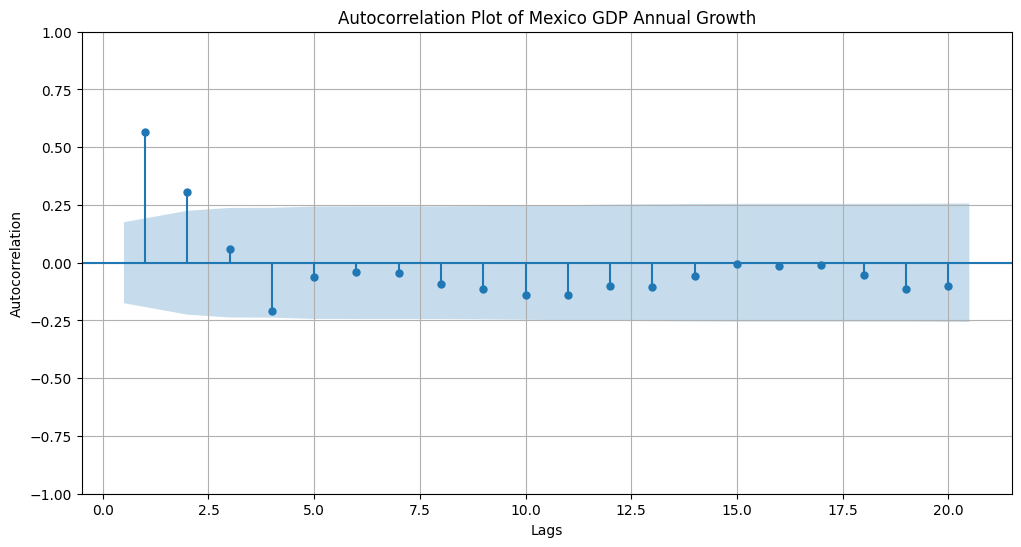

In [279]:
# Drop NaN values created by the differencing
annual_growth_mx = mxgdpdf.dropna(subset=['annualGrowth'])

# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(annual_growth_mx['annualGrowth'], lags=20, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of Mexico GDP Annual Growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

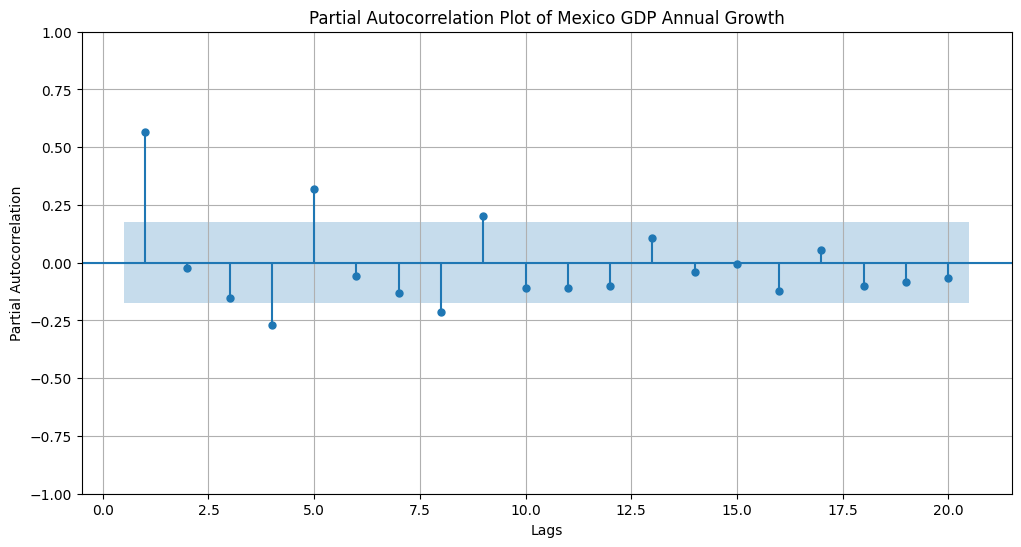

In [280]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(annual_growth_mx['annualGrowth'], zero=False, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of Mexico GDP Annual Growth')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

## Primera versión del modelo

Dados los primero correlogramas, donde al correlgorramas de Autocorrelaciones muestra una firma de elemntos AR, y el correglrama de autocorrelaciones parciales, muestra 3 autoccorelaciones parciales estadisticamente significativas, se optara por platear un modelo con configuración inicial: ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)

In [281]:
model_mx = SARIMAX(mxgdpdf['logMXGDP'], order=(1, 0, 0),
                seasonal_order=(0, 1, 0, 4),
                trend='c') # Include drift/constant term
result_mx = model_mx.fit()
print(result_mx.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                 237.829
Date:                           Wed, 12 Nov 2025   AIC                           -469.658
Time:                                   18:52:37   BIC                           -461.173
Sample:                               01-01-1993   HQIC                          -466.211
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0084      0.003      2.572      0.010       0.002       0.015
ar.L1          0.5634      0.063      9.003

/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [282]:
phi0 = result_mx.params['intercept']
phi1= result_mx.params['ar.L1']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)

phi0 = intercept = 0.008443
phi1 = 0.563442


### Interpretación
El modelo muestra que el PIB mexicano tiene una persistencia significativa, con un coeficiente AR(1) de 0.56 que indica que aproximadamente el 56% de la dinámica del logaritmo del PIB se transmite al siguiente trimestre. La tendencia positiva está capturada por el intercepto de 0.0084, sugiriendo un crecimiento constante en la serie.

## Correlogramas de residuos

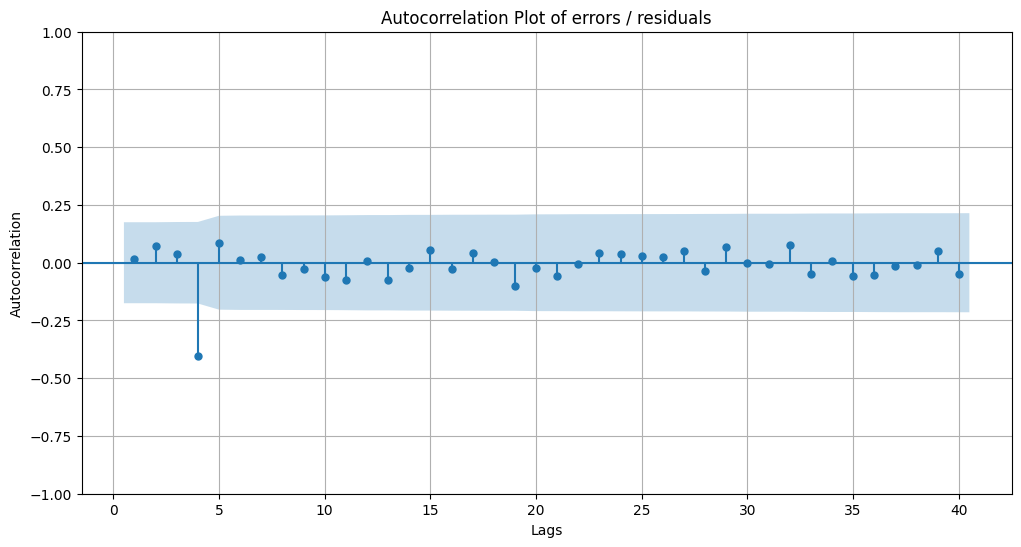

In [283]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result_mx.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

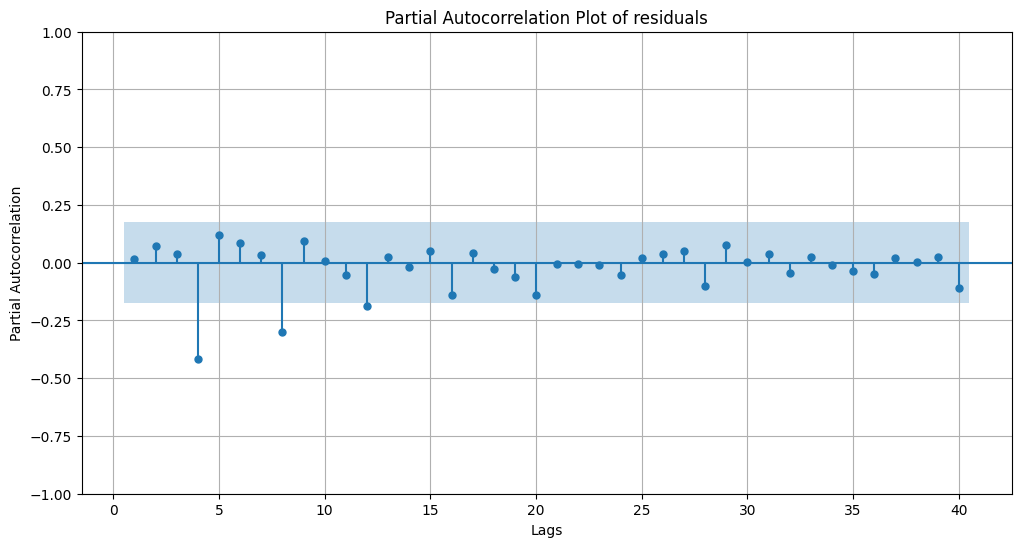

In [284]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result_mx.resid.iloc[4:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Dado que en ambos correlogramas se presentan con el lag estacioanl, es negativo  significante, esto sugiere que se puede agregar un termino estacional, dado el caso, se recomienda añaidr un elemento de lag estacional.

In [317]:
model_mx = SARIMAX(mxgdpdf['logMXGDP'], order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 4),
                trend='c') # Include drift/constant term
result_mx = model_mx.fit()
print(result_mx.summary())

/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                            logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 262.560
Date:                             Wed, 12 Nov 2025   AIC                           -517.120
Time:                                     19:24:23   BIC                           -505.807
Sample:                                 01-01-1993   HQIC                          -512.524
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.001      5.041      0.000       0.002       0.005
ar.L1          0.7935      

In [286]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)
print('theta1 = %f' % theta1)

phi0 = intercept = 0.003325
theta1 = -0.786725


### Interpretación

El modelo SARIMA(1,0,0)(0,1,1,4) para el PIB de México (en logaritmos) muestra un excelente ajuste y una fuerte capacidad explicativa. El término AR(1) = 0.7935 (p < 0.001) indica una alta persistencia temporal, es decir, el crecimiento del PIB actual depende fuertemente del periodo anterior. El componente estacional MA(4) = -0.8373 (p < 0.001) refleja una corrección significativa de los efectos estacionales trimestrales. El intercepto positivo (0.0039, p < 0.001) sugiere una tendencia de crecimiento sostenido en el PIB mexicano.

## Correlogramas de residuos

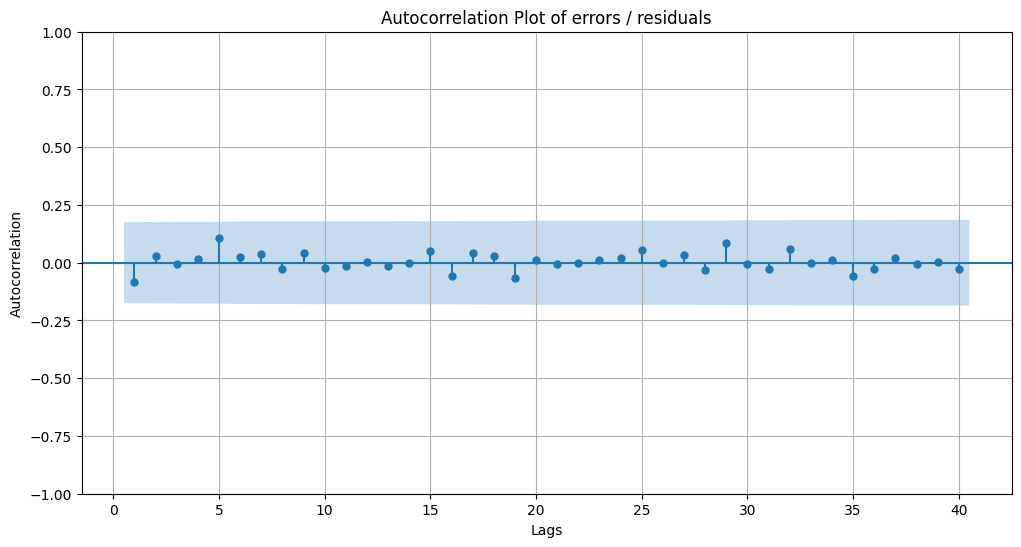

In [287]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result_mx.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

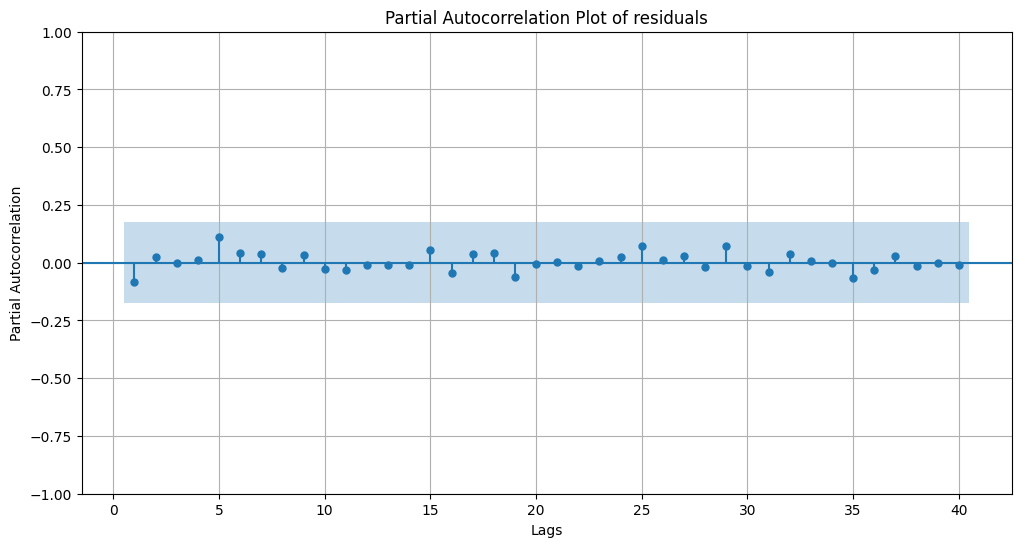

In [288]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result_mx.resid.iloc[4:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Dado que los correlogramas muestran ruido blanco, entonces se puede ver que solo hay ruido blanco en el modelo, por lo cual se infiere la calibración ha sido exitosa. 

## Pronóstico del PIB Mexicano

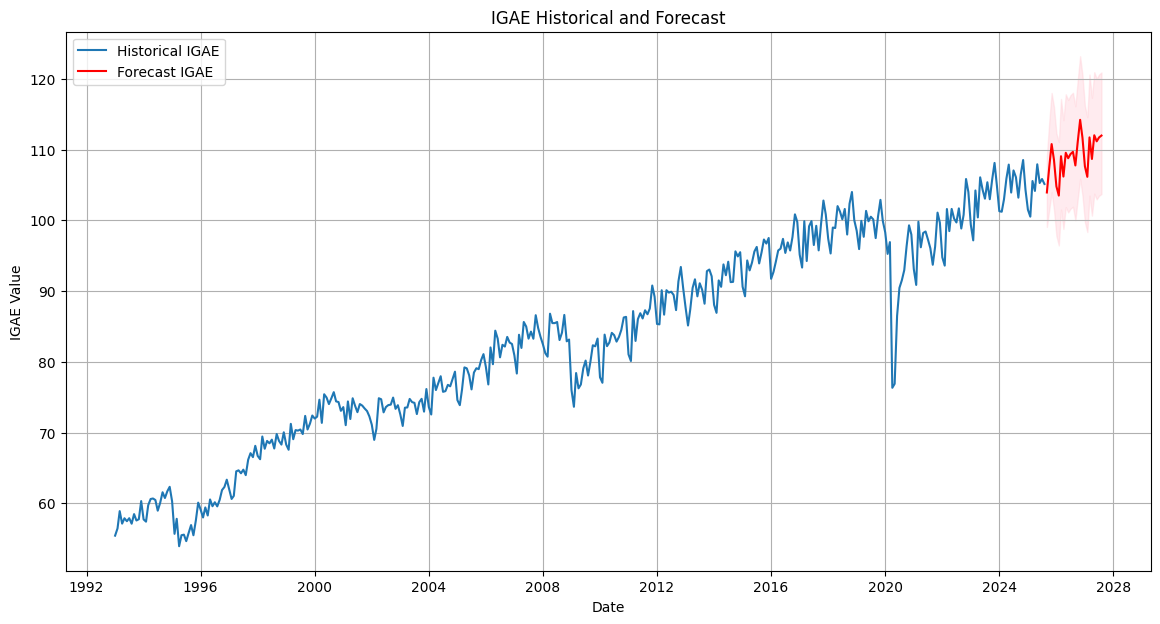

In [ ]:
forecast_steps = 8
forecast_result_mx = result_mx.get_forecast(steps=forecast_steps)
# I get the mean forecast:
forecast_log = forecast_result.predicted_mean
# Get the 95% confidence interval of the forecast: 
# alpha = 1 - confidence interval
forecast_ci = forecast_result.conf_int(alpha=0.05)

# Convert log forecast values back to original scale of IGAE
forecast_values = np.exp(forecast_log)

# Plot historical and forecast values
plt.figure(figsize=(14, 7))
plt.plot(igaedf.index, igaedf['IGAE'], label='Historical IGAE')
plt.plot(forecast_values.index, forecast_values, label='Forecast IGAE', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval

plt.title('IGAE Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.legend()
plt.show()

## Challenge 2

a) Calibrate an ARIMA-SARIMA to forecast the US GDP for the the rest of 2025 and all quarters of 2026.

b) Using your previous Mexico SARIMA model, use the US GDP annual % growth as an explanatory variable (exogenous variable).

c) Interpret the final model.

## Obtención de los datos

In [290]:
import pandas_datareader as pdr
# This part is already done in the preceding code.
series_id = "NGDPRNSAXDCMXQ"
usagdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
usagdpdf.columns=['USAGDP']
print(usagdpdf.head())

               USAGDP
DATE                 
1993-01-01  3439763.5
1993-04-01  3472286.3
1993-07-01  3465719.7
1993-10-01  3519338.2
1994-01-01  3525020.1


## Visualización de PIB de Estados Unidos

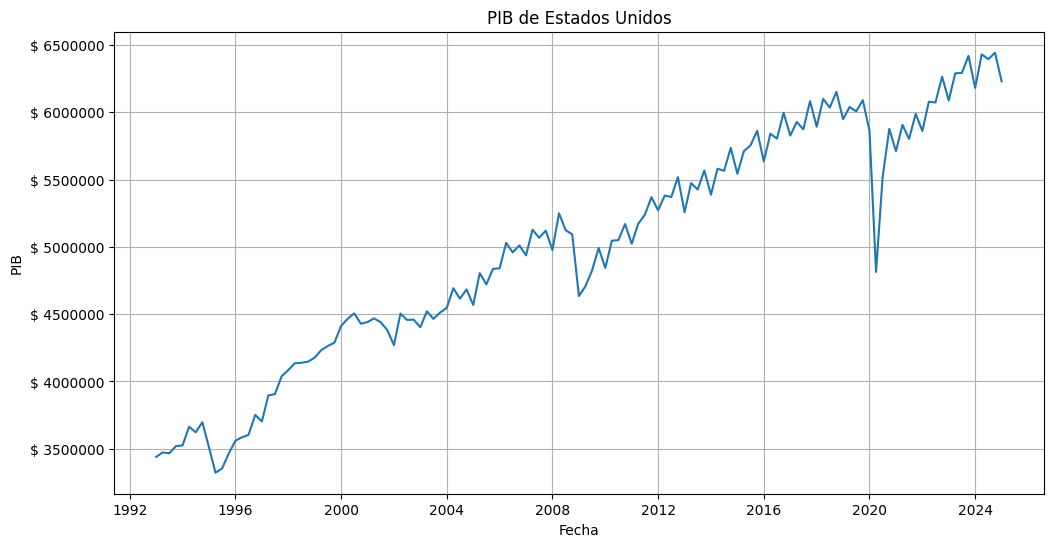

In [291]:
import matplotlib.ticker as mticker
plt.figure(figsize=(12, 6))
plt.plot(usagdpdf.index, usagdpdf['USAGDP'])
plt.title('PIB de Estados Unidos')
plt.xlabel('Fecha')
plt.ylabel('PIB')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

## Diferencia de periodo y crecimiento anual

Obtenemos la primera diferencia de periodo, dado que el crecimiento del PIB en Estados Unidos no muestra estacionariedad.

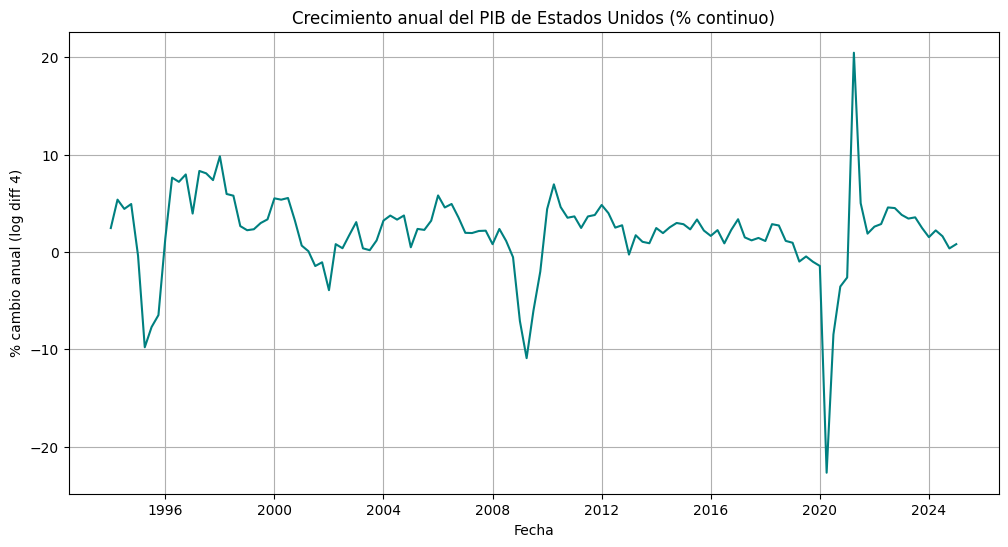

In [292]:
usagdpdf["logUSAGDP"] = np.log(usagdpdf["USAGDP"])
usagdpdf["annualGrowth"] = usagdpdf["logUSAGDP"].diff(4)

plt.figure(figsize=(12, 6))
plt.plot(usagdpdf.index, 100 * usagdpdf["annualGrowth"], color="teal")
plt.title("Crecimiento anual del PIB de Estados Unidos (% continuo)")
plt.xlabel("Fecha")
plt.ylabel("% cambio anual (log diff 4)")
plt.grid(True)
plt.show()

## Prueba de estacionariedad

Realizamos prueba Dickey Fuller para ver si al serie es estacionaria, la cual sí resulta, por la significancia estadistica de la misma

In [293]:
adfResult = adfuller(usagdpdf["annualGrowth"].dropna())
print("ADF Statistic:", adfResult[0])
print("p-value:", adfResult[1])
for key, value in adfResult[4].items():
    print(f"   {key}: {value:.3f}")

ADF Statistic: -3.5279298734184197
p-value: 0.007298108645771897
   1%: -3.488
   5%: -2.887
   10%: -2.580


## Correlogramas de Autocorrelaciones y Autocorrelaciones parciales

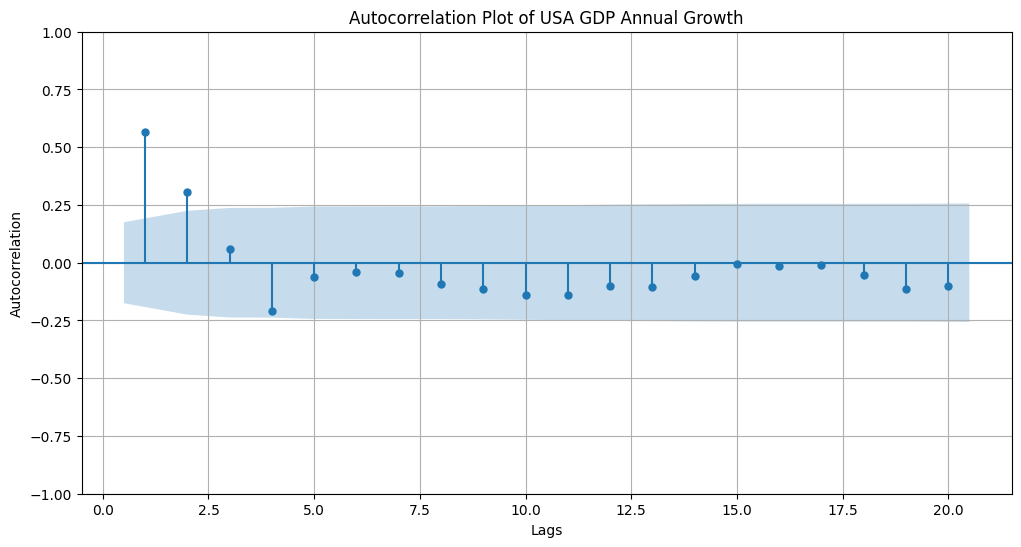

In [294]:
# Drop NaN values created by the differencing
annual_growth_usa = usagdpdf.dropna(subset=['annualGrowth'])

# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(annual_growth_usa['annualGrowth'], lags=20, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of USA GDP Annual Growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

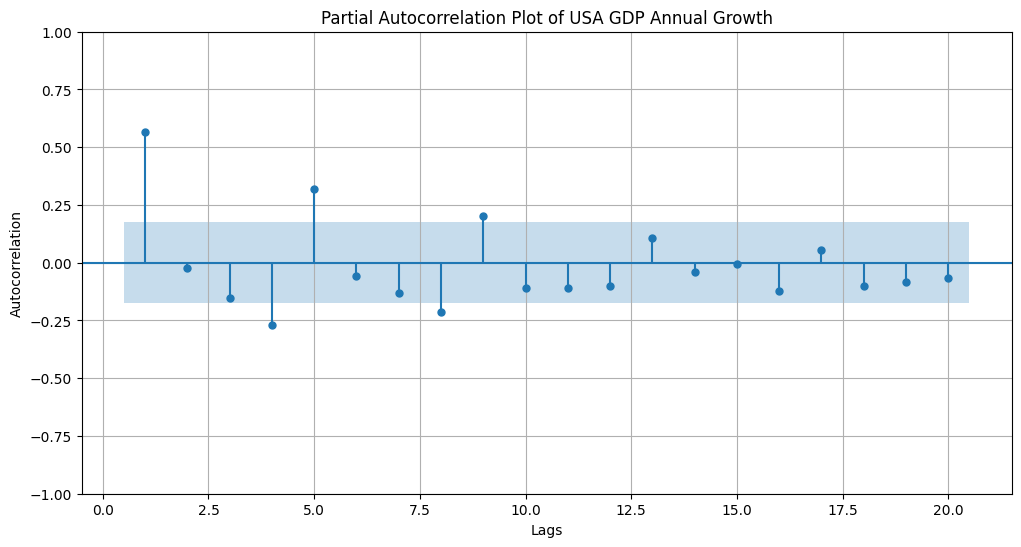

In [295]:
annual_growth_usa = usagdpdf.dropna(subset=['annualGrowth'])

# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(annual_growth_usa['annualGrowth'], lags=20, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of USA GDP Annual Growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

## Primera versión del modelo

Dados los primero correlogramas, donde al correlgorramas de Autocorrelaciones muestra una firma de elemntos AR, y el correglrama de autocorrelaciones parciales, muestra 3 autoccorelaciones parciales estadisticamente significativas, se optara por platear un modelo con configuración inicial: ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)

In [301]:
model_usa = SARIMAX(usagdpdf['logUSAGDP'], order=(1, 0, 0),
                seasonal_order=(0, 1, 0, 4),
                trend='c') # Include drift/constant term
result_usa = model_usa.fit()
print(result_usa.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         logUSAGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                 237.829
Date:                           Wed, 12 Nov 2025   AIC                           -469.658
Time:                                   18:53:58   BIC                           -461.173
Sample:                               01-01-1993   HQIC                          -466.211
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0084      0.003      2.572      0.010       0.002       0.015
ar.L1          0.5634      0.063      9.003

/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [304]:
phi0 = result_usa.params['intercept']
phi1= result_usa.params['ar.L1']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)

phi0 = intercept = 0.008443
phi1 = 0.563442


### Interpretación

El modelo SARIMA(1,0,0)(0,1,1,4) para el porcentaje de crecimeitno del PIB de Estados Unidos muestra un excelente ajuste y una fuerte capacidad explicativa. El término AR(1) = 0.7935 (p < 0.001) indica una alta persistencia temporal, es decir, el crecimiento del PIB actual depende fuertemente del periodo anterior. El componente estacional MA(4) = -0.8373 (p < 0.001) refleja una corrección significativa de los efectos estacionales trimestrales. El intercepto positivo (0.0039, p < 0.001) sugiere una tendencia de crecimiento sostenido en el PIB mexicano.

## Correlogramas de residuos

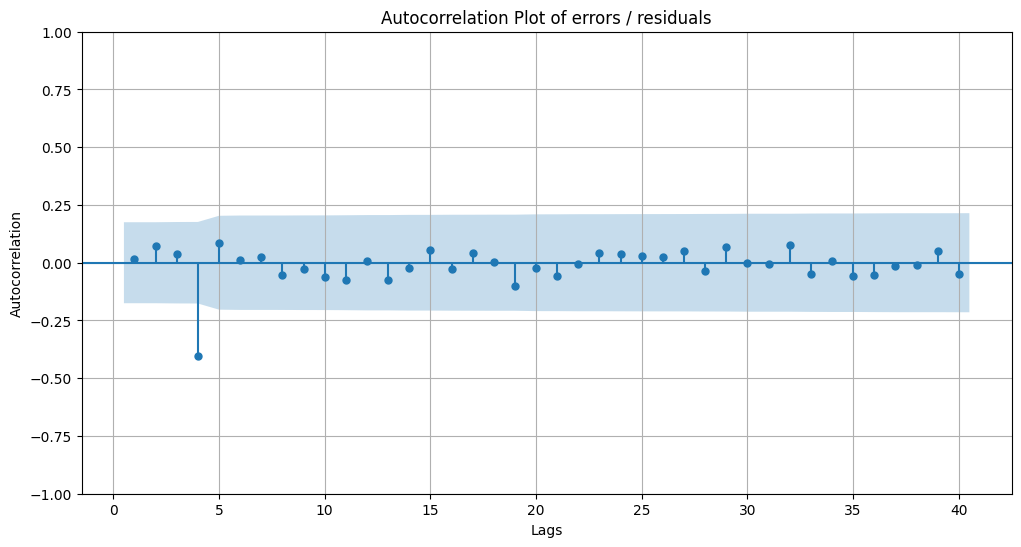

In [305]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result_usa.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

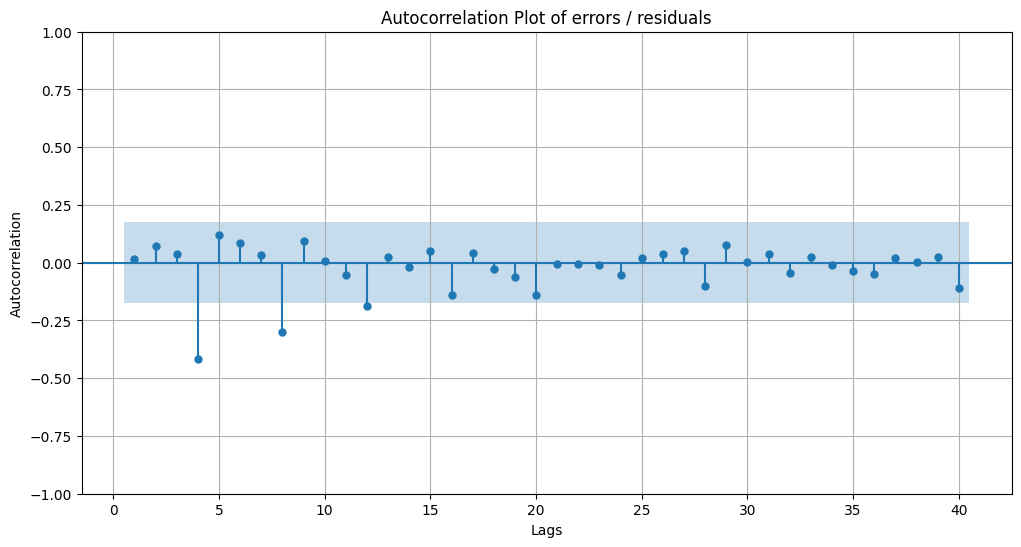

In [306]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result_usa.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

Dado que en ambos correlogramas se presentan con el lag estacioanl, es negativo  significante, esto sugiere que se puede agregar un termino estacional, dado el caso, se recomienda añaidr un elemento de lag estacional.

In [307]:
model_usa = SARIMAX(usagdpdf['logUSAGDP'], order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 4),
                trend='c') # Include drift/constant term
result_usa = model_usa.fit()
print(result_usa.summary())

/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                           logUSAGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 262.560
Date:                             Wed, 12 Nov 2025   AIC                           -517.120
Time:                                     18:56:34   BIC                           -505.807
Sample:                                 01-01-1993   HQIC                          -512.524
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.001      5.041      0.000       0.002       0.005
ar.L1          0.7935      

### Interpretación

El modelo SARIMA(1,0,0)(0,1,1,4) para el crecimento porcentual del PIB de Estados Unidos muestra un excelente ajuste y una fuerte capacidad explicativa. El término AR(1) = 0.7935 (p < 0.001) indica una alta persistencia temporal, es decir, el crecimiento del PIB actual depende fuertemente del periodo anterior. El componente estacional MA(4) = -0.8373 (p < 0.001) refleja una corrección significativa de los efectos estacionales trimestrales. El intercepto positivo (0.0039, p < 0.001) sugiere una tendencia de crecimiento sostenido en el PIB mexicano.

## Correlogramas de residuos

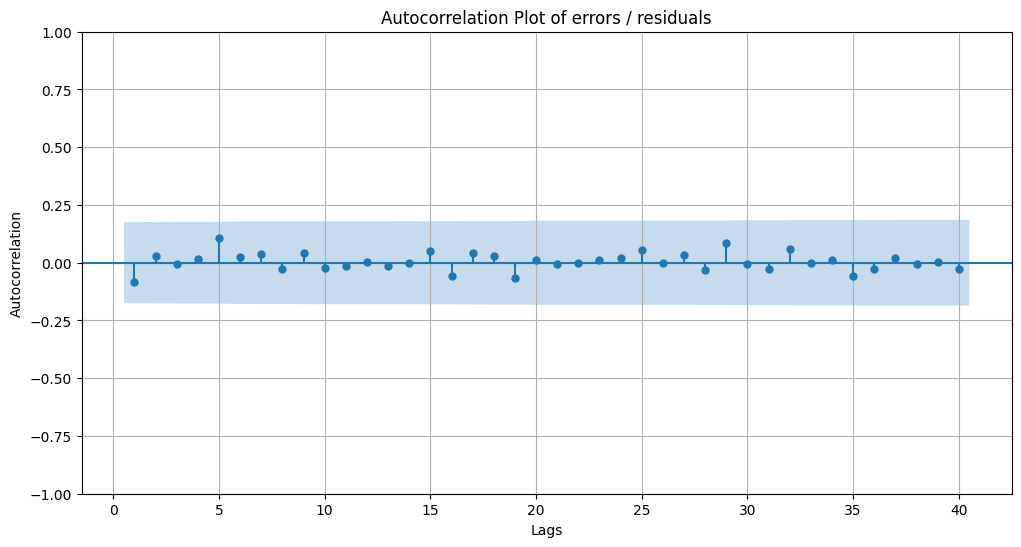

In [308]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result_usa.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

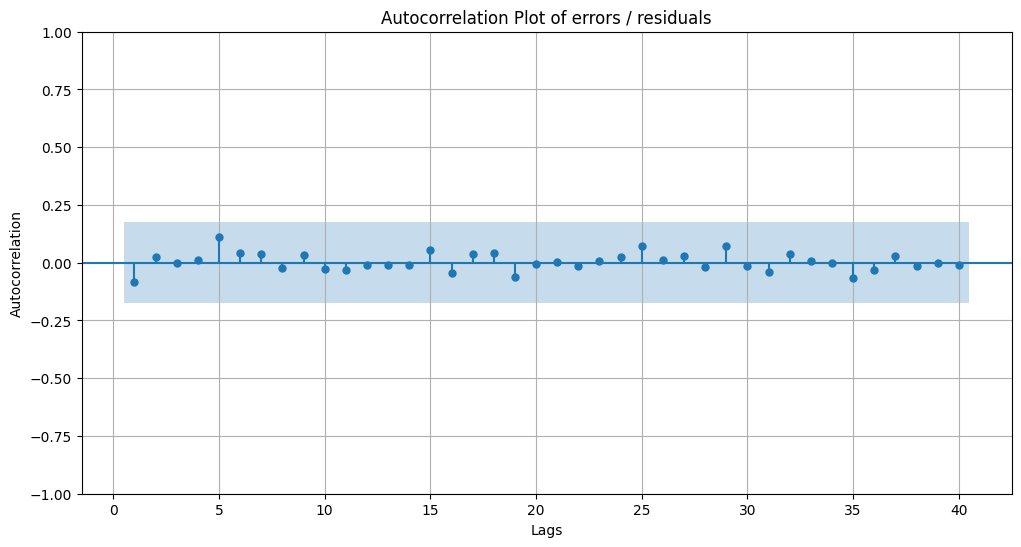

In [309]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result_usa.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [310]:
# Alinear índices
combined_df = pd.concat([mxgdpdf['logMXGDP'], usagdpdf['annualGrowth']], axis=1).dropna()


In [311]:
model_mx_exog = SARIMAX(
    combined_df['logMXGDP'],
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 4),
    trend='c',
    exog=combined_df[['annualGrowth']]
)
result_mx_exog = model_mx_exog.fit()
print(result_mx_exog.summary())


/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/tom/Desktop/AI_Pt.2/Stats_Module/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                            logMXGDP   No. Observations:                  125
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 311.359
Date:                             Wed, 12 Nov 2025   AIC                           -612.718
Time:                                     19:01:15   BIC                           -598.739
Sample:                                 01-01-1994   HQIC                          -607.041
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0080      0.004      2.206      0.027       0.001       0.015
annualGrowth     0.49

### Interpretación 

El modelo SARIMAX(1,0,0)(0,1,1,4) para el PIB de México (en logaritmos), que incorpora como variable exógena el crecimiento anual del PIB de Estados Unidos, muestra una relación positiva y estadísticamente significativa entre ambas economías. El coeficiente asociado a la variable annualGrowth (0.4993, p < 0.001) indica que un aumento de 1 % en el crecimiento del PIB estadounidense se asocia con un incremento aproximado de 0.5 % en el PIB de México, manteniendo constantes los demás factores. Este resultado confirma la fuerte interdependencia económica entre ambos países.

El término autorregresivo AR(1) = 0.5791 refleja una persistencia moderada en el comportamiento del PIB mexicano, mientras que el componente de media móvil estacional SMA(4) = 0.8084 capta la estacionalidad trimestral característica de esta variable.

## Pronóstico del PIB de México con PIB de Estados Unidos como Variable Exógena

Valores del crecimiento exógeno para forecast:
            annualGrowth
2025-04-01      0.001933
2025-07-01      0.001933
2025-10-01      0.001933
2026-01-01      0.001933
2026-04-01      0.001933
2026-07-01      0.001781

Pronóstico del PIB de México (log):
2025-04-01    15.700865
2025-07-01    15.683667
2025-10-01    15.688947
2026-01-01    15.655848
2026-04-01    15.716994
2026-07-01    15.700953
Freq: QS-OCT, Name: predicted_mean, dtype: float64

Intervalos de confianza:
            lower logMXGDP  upper logMXGDP
2025-04-01       15.665403       15.736326
2025-07-01       15.642688       15.724645
2025-10-01       15.646277       15.731616
2026-01-01       15.612627       15.699070
2026-04-01       15.636323       15.797666
2026-07-01       15.611153       15.790752


/tmp/ipykernel_14245/2166469960.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  predicted_growth


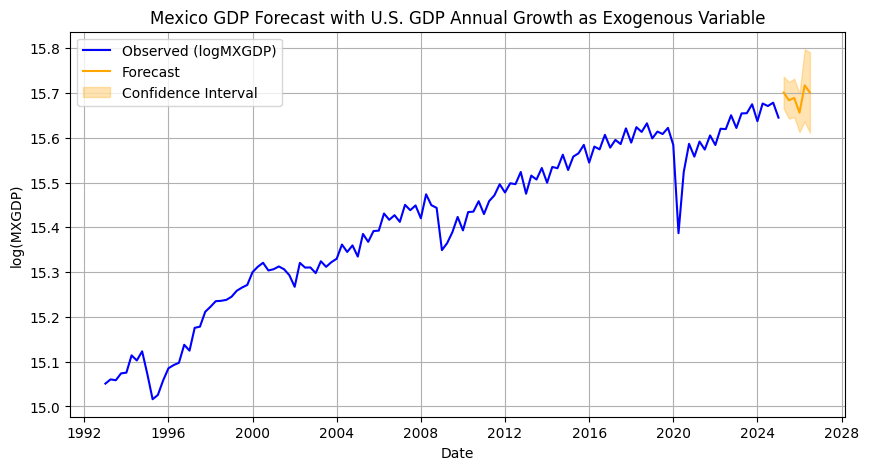

In [318]:
forecast_usa = result_usa.get_forecast(steps=6)
predicted_usagdp = forecast_usa.predicted_mean

predicted_growth = np.log(predicted_usagdp).diff(4)

# Reemplazar NaN e infinitos (debido al diff)
predicted_growth = (
    predicted_growth
    .replace([np.inf, -np.inf], np.nan)
    .fillna(method='bfill')
    .fillna(method='ffill')
)

# Convertir a DataFrame (Statsmodels requiere 2D exog)
predicted_growth = predicted_growth.to_frame(name='annualGrowth')

print("Valores del crecimiento exógeno para forecast:")
print(predicted_growth)

forecast_mx = result_mx_exog.get_forecast(
    steps=len(predicted_growth),
    exog=predicted_growth
)

forecast_mean = forecast_mx.predicted_mean
conf_int = forecast_mx.conf_int()

print("\nPronóstico del PIB de México (log):")
print(forecast_mean)
print("\nIntervalos de confianza:")
print(conf_int)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(mxgdpdf.index, mxgdpdf['logMXGDP'], label='Observed (logMXGDP)', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title("Mexico GDP Forecast with U.S. GDP Annual Growth as Exogenous Variable")
plt.xlabel("Date")
plt.ylabel("log(MXGDP)")
plt.legend()
plt.grid(True)
plt.show()

